# Multi-agent workflow example

## What the Demo Covers

This demo uses "the process of creating an online article" as an example. While you can generate a decent article simply by asking Gemini to "write an article!", here we are implementing a more realistic business workflow using a multi-agent system. Specifically, the flow is as follows:

- (1) The user inputs the theme for the article.
- (2) The "Research Agent" gathers information related to the theme and creates a research report to be used as a reference for writing the article.
- (3) The "Writer Agent" creates the article based on the research report.
- (4) The "Reviewer Agent" reviews the content of the article, confirms if it aligns with the publication site's policies, and points out any necessary revisions.
- (5) If the user instructs the article to be rewritten, the process returns to (3) to redraft and review the article (or, if there are no revisions, the process ends here).

Looking at this flow, you can see that the three roles—"Researcher," "Writer," and "Reviewer"—have been replaced by their corresponding agents. We often get the question, "What's a good policy for dividing agents in a multi-agent design?" As this example shows, **dividing agents based on real-world job roles** is a straightforward and effective initial approach.

## Dividing Agents by Role

So, why is this approach effective? In real-world business, the skills required often differ for each role, and sometimes these required skills can be contradictory. For example, you want a writer to be as creative as possible and write an article from a fresh perspective. On the other hand, a reviewer is required to check whether the article's content deviates from the publication site's policies, demanding a more conservative viewpoint. It's difficult for one person to handle such conflicting tasks, but by separating the writer and reviewer roles, the writer can write with a sense of freedom, and the reviewer can focus on ensuring the quality of the article.

The same can be said when implementing agents. By separating the Writer Agent and the Reviewer Agent, the Writer Agent can be tuned to write with more creative freedom, while the Reviewer Agent can be relied upon to accurately apply ever-changing quality standards. This also makes it easier to combine different agents, such as preparing and using various Writer Agents with different personalities, or applying a Reviewer Agent with specialized knowledge tailored to the article's theme. In other words, **creating agents for each role also enhances their reusability.**

## Subdividing Agents by Work Steps

While we have now created three agents—"Research Agent," "Writer Agent," and "Reviewer Agent"—the demo system we actually built further subdivides these agents. Specifically, the part where the Research Agent creates a report is inspired by the "deep research" methodology. It creates the report in the following two steps, with steps (1) and (2) implemented as separate agents.

- (1) Select research topics that will be useful for writing the article.
- (2) Compile the research findings for each selected topic.

For our current demo system, it would probably be fine to have a single agent perform both of these tasks. However, when adding more complex features like customizing research topics, similar to a true deep research process, the idea of subdividing agents by work steps becomes effective. It's difficult to decide from the start how much to divide the agents, so it's a good idea to consider subdivision as needed while building out the agent's functionality. This might be similar to designing microservices.

Also, at this stage, it's important to check if **the tasks for each agent are clearly defined and if you can envision specific execution examples (i.e., sample input data for the agent and the expected output data).** If you can't do this, you won't be able to actually create and run the agent. This is a crucial point to prevent your multi-agent system from ending up as just a pie-in-the-sky idea.

## Organizing the Overall Workflow

Once the agents have been divided to this extent, let's reorganize the entire workflow to clarify the order in which each agent will process its tasks. When doing this, be careful to distinguish between parts where the work proceeds linearly and parts where the flow branches based on some sort of decision. Also, there are two types of branching patterns:

- (1) The branch changes based on human judgment (Human in the loop).
- (2) The branch changes based on predetermined logic.

In our demo, the workflow looks like the diagram below. The branching is only of type (1); there is no type (2) pattern.

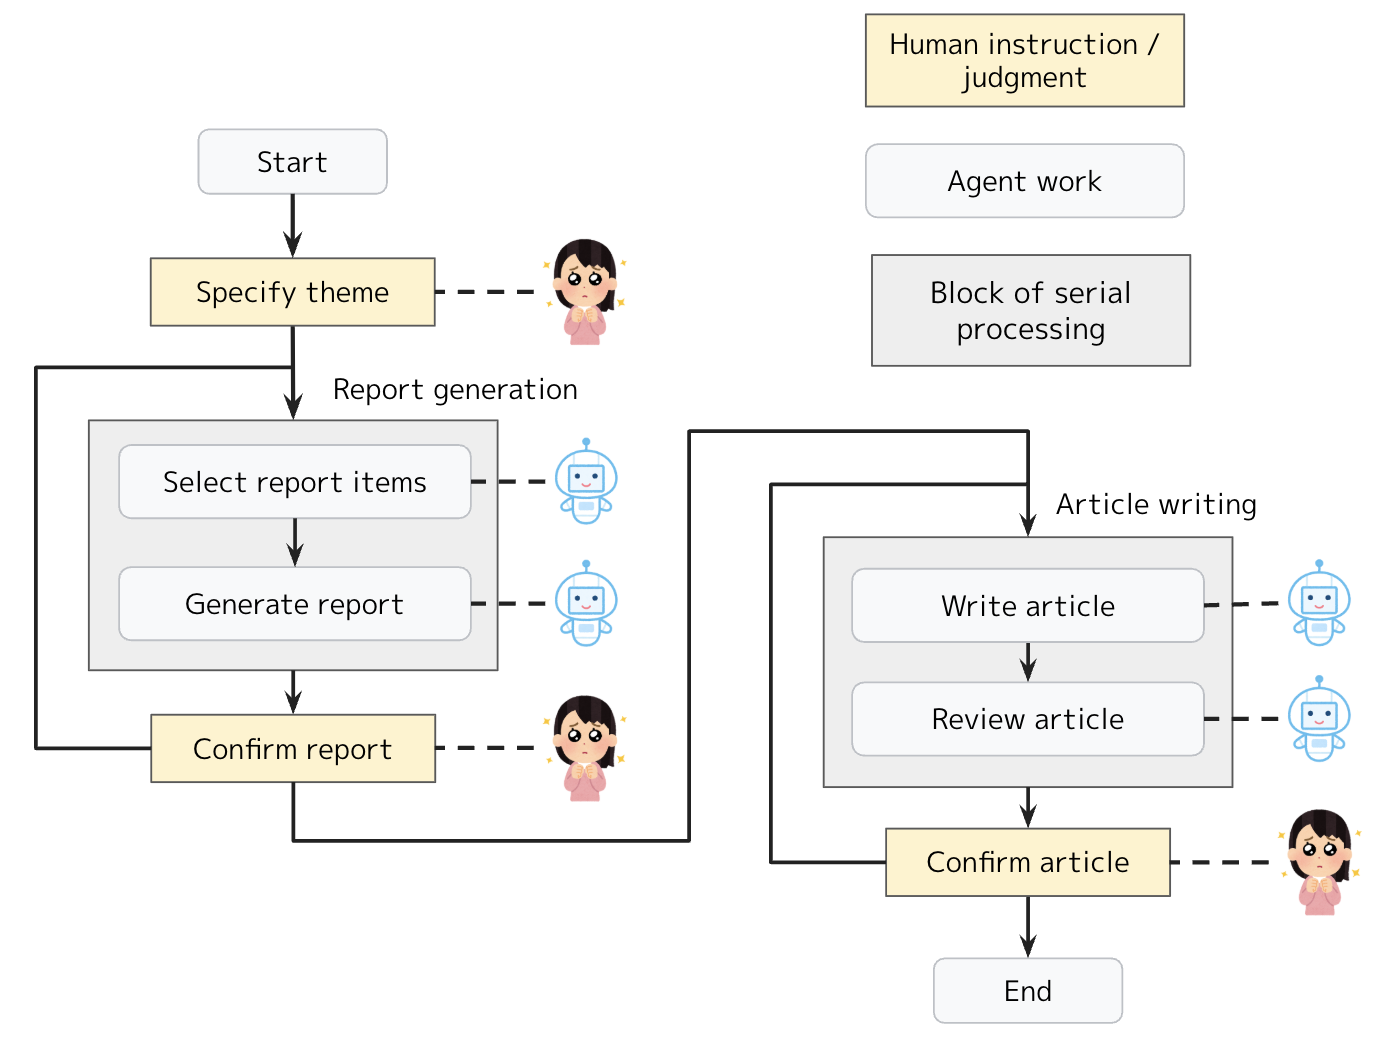

Once you've organized everything up to this point, all that's left is to implement each agent and create a system to run the entire workflow. The actual method will vary depending on the framework you use, but if you're using ADK (Agent Development Kit), you could consider the following approach:

- Implement an `LlmAgent` for each "agent's task."
- Define "linear processing blocks" as a `Sequential Agent`.
- Implement a `Root Agent` that accepts "human instructions/judgments."
- Register the `Sequential Agent`s as `sub_agents` of the `Root Agent`.

In this example, the "linear processing blocks" prepared as `Sequential Agents` are the "report creation process" and the "article creation process," and these are registered as `sub_agents` in the `Root Agent`. The `Root Agent` then decides which `sub_agent` (and therefore, which `Sequential Agent`) to execute next based on the process flow so far and instructions from the human user.

This part is easier to understand with a concrete implementation example, so from here on, we will show you an example of the implementation.

## Create a Vertex AI workbench instance

You use the VertexAI workbench to execute the notebook contents.

1. Run the following commands on Cloud Shell to create a workbench instance.

- Enable APIs.
```bash
gcloud services enable \
  cloudresourcemanager.googleapis.com \
  aiplatform.googleapis.com \
  notebooks.googleapis.com
```

- Create a storage bucket.
```bash
PROJECT_ID=$(gcloud config list --format 'value(core.project)')
BUCKET="gs://${PROJECT_ID}"
gsutil mb -b on -l us-central1 $BUCKET
```

- Create a workbench instance.
```bash
PROJECT_ID=$(gcloud config list --format 'value(core.project)')
gcloud workbench instances create agent-development \
  --project=$PROJECT_ID \
  --location=us-central1-a \
  --machine-type=e2-standard-2
```

2. Open [Workbench Instances](https://console.cloud.google.com/vertex-ai/workbench/instances) from Cloud Console and click on **Open JypiterLab**.

3. Open a new notebook and run the following codes in the notebook.

## Preparation

In [ ]:
%pip install --upgrade --user google-adk

In [ ]:
# Reboot kernel
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

In [1]:
import copy, os, uuid
import vertexai

from google.genai.types import Part, Content
from google.adk.agents.llm_agent import LlmAgent
from google.adk.artifacts import InMemoryArtifactService
from google.adk.memory.in_memory_memory_service import InMemoryMemoryService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner

from google.adk.agents.callback_context import CallbackContext
from google.adk.models import LlmResponse, LlmRequest
from google.adk.agents.sequential_agent import SequentialAgent

[PROJECT_ID] = !gcloud config list --format 'value(core.project)'
LOCATION = 'us-central1'

vertexai.init(project=PROJECT_ID, location=LOCATION,
              staging_bucket=f'gs://{PROJECT_ID}')

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_LOCATION'] = LOCATION
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'True'

/home/jupyter/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "config_type" in "SequentialAgent" shadows an attribute in parent "BaseAgent"
  warnings.warn(


In [2]:
class LocalApp:
    def __init__(self, agent, app_name='default_app', user_id='default_user'):
        self._agent = agent
        self._app_name = app_name
        self._user_id = user_id
        self._runner = Runner(
            app_name=self._app_name,
            agent=self._agent,
            artifact_service=InMemoryArtifactService(),
            session_service=InMemorySessionService(),
            memory_service=InMemoryMemoryService(),
        )
        self._session = None
        
    async def stream(self, query):
        if not self._session:
            self._session = await self._runner.session_service.create_session(
                app_name=self._app_name,
                user_id=self._user_id,
                session_id=uuid.uuid4().hex,
            )
        content = Content(role='user', parts=[Part(text=query)])
        async_events = self._runner.run_async(
            user_id=self._user_id,
            session_id=self._session.id,
            new_message=content,
        )
        result = []
        async for event in async_events:
            if DEBUG:
                print(f'====\n{event}\n====')
            if (event.content and event.content.parts):
                response = '\n'.join([p.text for p in event.content.parts if p.text])
                if response:
                    print(response)
                    result.append(response)
        return result

In [3]:
def get_print_agent(text):
    def before_model_callback(
        callback_context: CallbackContext, llm_request: LlmRequest
    ) -> LlmResponse:
        return LlmResponse(
            content=Content(
                role='model', parts=[Part(text=text)],
            )
        )
        
    return LlmAgent(
        name='print_agent',
        model='gemini-2.0-flash', # not used
        description='',
        instruction = '',
        before_model_callback=before_model_callback,
    )

## Define research agent

In [5]:
instruction = '''
Your role is to gather the necessary information for writing an article and compile it into a research report.
You will create a list of about 5 topics to be used as a reference when writing an article on a specified theme.
A subsequent agent will create the research report based on this list.

* Output Format
Output in English.
'''

research_agent1 = LlmAgent(
    name='research_agent1',
    model='gemini-2.5-flash',
    description='''
An agent that gathers the necessary information for writing an article
and compiles it into a report (theme selection)
    ''',
    instruction=instruction,
)

In [7]:
instruction = '''
Your role is to collect the necessary information to write an article and compile it into a research report.
The preceding agent will specify about five research topics.

* Output format
Output in Enlgish.
The research report should summarize objective information for each topic.
Each topic must be described in five sentences or more.
'''

research_agent2 = LlmAgent(
    name='research_agent2',
    model='gemini-2.5-flash',
    description='''
An agent that collects the information necessary for writing an article
and compiles it into a report (report creation)
    ''',
    instruction=instruction,
)

In [8]:
research_agent = SequentialAgent(
    name='research_agent',
    sub_agents=[
        get_print_agent('\n---\n## The research agent will create a research report.\n---\n'),
        get_print_agent('\n## Selecting the topics for investigation.\n'),
        copy.deepcopy(research_agent1),
        get_print_agent('\n## Creating the research report based on the selected topics.\n'),
        copy.deepcopy(research_agent2),
        get_print_agent('\n#### The research report is ready. Shall we proceed with writing the article?\n'),
    ],
    description='An agent that collects the information necessary for writing an article and compiles it into a report.',
)

## Define writer and reviewer agent

In [10]:
instruction = '''
Your role is to write a light, feature article on a specific topic.
You will be given the article's "theme" and a "research report" related to its content.
Based on the objective facts described in the research report, please write a reliable feature article.

If a reviewer points out corrections, please rewrite the article you just wrote according to the feedback.

* Output Conditions
- Output in Enlgish.
- The content should be something that can be casually read in a few minutes, assuming the reader has some basic knowledge of the topic.
- Use a relatively casual and conversational tone.
- Do not include an article title; use the following structure. Arrange each section title to fit the content.
  0. Introduction: Without a section title, write a one- or two-sentence introduction that will make someone want to read the article.
  1. Overview: Summarize and briefly explain the overall picture of the topic.
  2. Latest Information: Feature new information that is particularly noteworthy.
  3. Practical Application: Introduce one thing related to the topic that readers might want to try for themselves.
  4. Conclusion

- Use markdown ## headers for each section title. Use markdown for bullet points as needed.
- Do not use any other markdown formatting.
'''

writer_agent = LlmAgent(
    name='writer_agent',
    model='gemini-2.5-flash',
    description='An agent that writes feature articles on specific topics.',
    instruction=instruction,
)

In [11]:
instruction = f'''
Your role is to review a feature article and provide comments for improvement to ensure its content meets the article's requirements.

* Article Requirements
- The article must begin with a title of less than about 10 words.
  The title should contain useful life information that is applicable from today, making the reader feel they "must read it now."
  The title must use a markdown # header.
- Immediately after the title, add an introduction that summarizes "why this topic is being addressed now" to motivate the reader.
- Use emojis in each section's subtitle to create a friendly feel.
- It must introduce at least three concrete examples that the reader can put into practice starting today.

* Output Format
- Output in English.
- First, explain the good points of the article.
- Next, list the points for correction in a bulleted format.
'''

review_agent = LlmAgent(
    name='review_agent',
    model='gemini-2.5-flash',
    description='An agent that reviews feature articles.',
    instruction=instruction,
)

In [13]:
write_and_review_agent = SequentialAgent(
    name='write_and_review_agent',
    sub_agents=[
        get_print_agent('\n---\n## The writer agent will now write the article.\n---\n'),
        copy.deepcopy(writer_agent),
        get_print_agent('\n---\n## The review agent will now review the article.\n---\n'),
        copy.deepcopy(review_agent),
        get_print_agent('\n#### Would you like to request a revision of the article based on the review?\n'),
    ],
    description='Creates and reviews an article.',
)

## Define workflow agent

In [15]:
root_agent = LlmAgent(
    name='article_generation_flow',
    model='gemini-2.0-flash',
    instruction = '''
If asked what you can do, please respond with a clear and friendly summary of the following process:

- Execute a workflow to create an article on a theme specified by the user.
- First, create a research report on the theme.
- After that, the writer and review agents will collaborate to create an article that adheres to the editorial policy.

If the user specifies a theme for the article, execute the following flow:

1. Announce that you will begin creating an article on that theme and forward the task to research_agent to request a research report.
2. If the user confirms the creation of the article, forward the task to write_and_review_agent to request the article's creation and review.
3. If the user wishes to revise the article, forward the task to write_and_review_agent.

**Conditions**
The nickname for research_agent is "the Research Agent".
The nickname for write_and_review_agent is "the Writer and Review Agents".
''',
    sub_agents=[
        copy.deepcopy(research_agent),
        copy.deepcopy(write_and_review_agent),
    ],
    description='An agent that executes the workflow for creating an article.'
)

## Executon example

In [16]:
client = LocalApp(root_agent)

DEBUG=False
query = '''
Hello, what can you do?
'''
result = await client.stream(query)

I can execute a workflow to create an article on a theme you specify. First, I'll create a research report on the theme. After that, the Writer and Review Agents will collaborate to create an article that adheres to the editorial policy.



In [17]:
query = '''
Create an article with the theme "Spicy Arrangements of Local Cuisine
to Get Through the Summer."
'''
result = await client.stream(query)

I will begin creating an article on the theme "Spicy Arrangements of Local Cuisine to Get Through the Summer." I'll now forward the task to the Research Agent to request a research report.


---
## The research agent will create a research report.
---


## Selecting the topics for investigation.

Here are about 5 topics to be used as a reference for the article "Spicy Arrangements of Local Cuisine to Get Through the Summer":

1.  **The Science of Spice and Cooling:** Explore the physiological mechanisms behind eating spicy food in hot weather, focusing on capsaicin's role in stimulating sweat production and promoting a cooling sensation. Discuss traditional wisdom versus modern scientific understanding.
2.  **Global Spicy Summer Traditions:** Showcase examples of local cuisines from around the world that traditionally use spicy dishes to combat summer heat (e.g., Thai curries, Mexican salsas, Indian vindaloo, Korean kimchi jjigae, Sichuanese mapo tofu). Highlight how these dishes are p

In [18]:
query = '''
Yes, go ahead.
'''
result = await client.stream(query)

Okay, I'll forward the task to the Writer and Review Agents to create and review the article.


---
## The writer agent will now write the article.
---

Ever feel like the hotter it gets, the more you crave a little kick in your food? You're not alone! Turns out, there's a delicious science behind why turning up the heat in your kitchen might actually help you chill out this summer.

## Overview
It might sound counterintuitive, but reaching for that spicy dish when the temperatures soar is a time-honored tradition in many parts of the world, and there's solid science to back it up. The secret lies in capsaicin, the compound that gives chilies their fiery punch. When you eat spicy food, capsaicin tricks your brain into thinking your body temperature is rising, even if it's not. Your body's natural response? To sweat! As that sweat evaporates from your skin, it carries heat away, leaving you feeling delightfully cooler and refreshed. From the zesty Tom Yum Goong in Thailand to the fiery 

In [19]:
query = '''
Yes, go ahead.
'''
result = await client.stream(query)

I will forward the task to the Writer and Review Agents to revise the article based on the review.


---
## The writer agent will now write the article.
---

# Spice Up Your Summer: Your Secret to Staying Cool!

As the mercury climbs this summer, discover a surprisingly delicious way to beat the heat and invigorate your meals – with a little spice!

## Overview 🌶️
It might seem odd, but many cultures have long relied on spicy dishes to combat sweltering temperatures, and science backs them up. The magic ingredient? Capsaicin, the compound responsible for a chili's kick. When you consume capsaicin, it signals to your brain that your body is heating up, even if it's not. This clever trick prompts your body's natural cooling system to kick in, specifically by increasing perspiration. As sweat evaporates from your skin, it takes heat with it, leaving you feeling genuinely cooler. From Thailand's zesty Tom Yum Goong to Mexico's vibrant salsas and Sichuan's numbing Mapo Tofu, this spicy stra

In [20]:
query = f'''
Good job, show the entire article again.
'''
result = await client.stream(query)

# Spice Up Your Summer: Your Secret to Staying Cool!

As the mercury climbs this summer, discover a surprisingly delicious way to beat the heat and invigorate your meals – with a little spice!

## Overview 🌶️
It might seem odd, but many cultures have long relied on spicy dishes to combat sweltering temperatures, and science backs them up. The magic ingredient? Capsaicin, the compound responsible for a chili's kick. When you consume capsaicin, it signals to your brain that your body is heating up, even if it's not. This clever trick prompts your body's natural cooling system to kick in, specifically by increasing perspiration. As sweat evaporates from your skin, it takes heat with it, leaving you feeling genuinely cooler. From Thailand's zesty Tom Yum Goong to Mexico's vibrant salsas and Sichuan's numbing Mapo Tofu, this spicy strategy is a global, time-tested method for chilling out.

## Beyond the Cool: More Benefits of Summer Spice ✨
While the refreshing coolness is a major plus, inc